In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
import argparse
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from sentence_transformers import SentenceTransformer

## train test split
from sklearn.model_selection import train_test_split


/home/dimitri/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
n_missing = 3
MODEL_PATH = "rnn_model.h5"
TOKENIZER_PATH = "tokenizer.pkl"
LABEL_ENCODER_PATH = "label_encoder.pkl"
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 128

In [3]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'train': 'train.csv', 'validation': 'dev.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/ibm-research/argument_quality_ranking_30k/" + splits["train"])

In [4]:
df.head()

,argument,topic,set,WA,MACE-P,stance_WA,stance_WA_conf
0,"""marriage"" isn't keeping up with the times. a...",We should abandon marriage,train,0.846165,0.297659,1,1.000000
1,.a multi-party system would be too confusing a...,We should adopt a multi-party system,train,0.891271,0.726133,-1,1.000000
2,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,train,0.730395,0.225212,-1,1.000000
3,"100% agree, should they do that, it would be a...",We should abolish safe spaces,train,0.236686,0.004104,1,0.805517
4,A ban on naturopathy creates a cohesive front ...,We should ban naturopathy,train,0.753805,0.337724,1,1.000000


In [ ]:
df_augmented_chat_gpt = pd.read_csv("./datasets_chatgpt.csv")

In [ ]:
argument = list(df.argument) + list(df_augmented_chat_gpt.argument)
topic = list(df.topic) + list(df_augmented_chat_gpt.topic)
note = list(df['MACE-P']) + list(df_augmented_chat_gpt['MACE-P'])

In [131]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
PADDINGS_TOPICS = 10
PADDINGS_ARGUMENTS = 100

nltk.download('punkt')

data = []
for i in range(len(argument)):
    arg_token = word_tokenize(argument[i].lower())
    arg_topic = word_tokenize(topic[i].lower())
    if len(arg_topic) < PADDINGS_TOPICS:
        arg_topic += ['<PAD>'] * (PADDINGS_TOPICS - len(arg_topic))
    if len(arg_token) < PADDINGS_ARGUMENTS:
        arg_token += ['<PAD>'] * (PADDINGS_ARGUMENTS - len(arg_token))

    data.append(arg_topic + arg_token)

model_embedding = Word2Vec(sentences=data, vector_size=100, window=5, min_count=1, workers=4)

print("Exemple de vocabulaire :", list(model_embedding.wv.key_to_index.keys())[:10])

[nltk_data] Downloading package punkt to /home/dimitri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Exemple de vocabulaire : ['<PAD>', 'should', 'we', 'the', 'to', '.', 'and', 'of', 'a', 'be']


In [132]:
import numpy as np

def sentence_to_vec(sentence, model):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
        else:
            vectors.append(np.zeros(model.vector_size))  # Use zero vector for unknown words
    return np.array(vectors)

In [133]:
X = np.array([sentence_to_vec(sent, model_embedding) for sent in data])

In [134]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, np.array(list(note)), test_size=0.2, random_state=42)

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
# Construire le modèle LSTM avec les embeddings de BERT
model = Sequential()

# Ajouter des couches bidirectionnelles LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(MAX_SEQUENCE_LENGTH, X.shape[-1]))))
model.add(Bidirectional(LSTM(64)))

# Ajouter des couches denses
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(loss='mean_absolute_error', optimizer='adam')

In [136]:
# Train and evaluate model with train and test
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32)

Epoch 1/2
525/525 [==============================] - 67s 121ms/step - loss: 0.3143 - val_loss: 0.2927
Epoch 2/2
525/525 [==============================] - 69s 132ms/step - loss: 0.2898 - val_loss: 0.2827


In [118]:
def prepare_data(topic, arg):
    arg_token = word_tokenize(arg.lower())
    arg_topic = word_tokenize(topic.lower())
    arg_topic += ['<PAD>'] * (PADDINGS_TOPICS - len(arg_topic))
    arg_token += ['<PAD>'] * (PADDINGS_ARGUMENTS - len(arg_token))
    return arg_topic + arg_token

def predict(arguments, topics):
    data = []
    for i in range(len(arguments)):
        data.append(prepare_data(topics[i], arguments[i]))
    X = []
    for i in range(len(data)):
        tmp = sentence_to_vec(data[i], model_embedding)
        X.append(tmp)
    X = np.array(X)
    y_pred = model.predict(X, verbose=0)
    return y_pred[:]
    

In [91]:
arg = "a zero tolerance policy means that parents would give complete control of discipline to the school without any regard for family morals and teachings."
top = "We should adopt a zero-tolerance policy in schools"
predict([arg], [top])

[['we', 'should', 'adopt', 'a', 'zero-tolerance', 'policy', 'in', 'schools', '<PAD>', '<PAD>', 'a', 'zero', 'tolerance', 'policy', 'means', 'that', 'parents', 'would', 'give', 'complete', 'control', 'of', 'discipline', 'to', 'the', 'school', 'without', 'any', 'regard', 'for', 'family', 'morals', 'and', 'teachings', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']]
ze

array([[0.88045317]], dtype=float32)

In [137]:
#load le test
df_test = pd.read_csv("hf://datasets/ibm-research/argument_quality_ranking_30k/" + splits["test"])
argument_test = list(df_test.argument)
topic_test = list(df_test.topic)
note_test = np.array(list(df_test.WA)).reshape(-1, 1)

In [138]:
predictions = []
batch_size = 32
acc = 0
stop = 200
for i in range(0, len(topic_test), batch_size):
    batch_topic = topic_test[i:i + batch_size]
    batch_argument = argument_test[i:i + batch_size]
    y_preds = predict(batch_argument, batch_topic)
    predictions.extend(y_preds)
    acc += np.sum(np.abs(y_preds - note_test[i:i + batch_size])) / len(y_preds)
    print("Batch {}: MAE = {}".format(i // batch_size, acc / (i // batch_size + 1)))
    if i >= stop:
        break
print("MAE = {}".format(acc / (i // batch_size + 1)))
predictions = np.array(predictions)[:,0]

    

Batch 0: MAE = 0.2158356538075695
Batch 1: MAE = 0.22164093464688128
Batch 2: MAE = 0.21231385644161838
Batch 3: MAE = 0.2096719306402134
Batch 4: MAE = 0.21266651551062427
Batch 5: MAE = 0.21324351517703952
Batch 6: MAE = 0.22501636153578478
Batch 7: MAE = 0.22376401933543455
MAE = 0.22376401933543455


# Data Viz

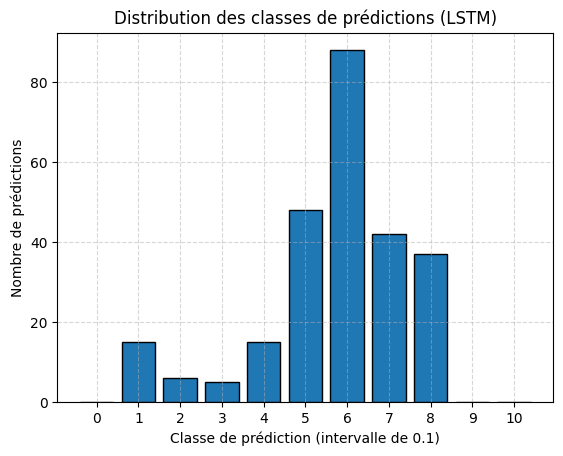

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de prédictions
preds = predictions
classes = np.floor(preds * 10).astype(int)

plt.hist(classes, bins=np.arange(12)-0.5, edgecolor='black', rwidth=0.8)
plt.xticks(range(11))
plt.xlabel("Classe de prédiction (intervalle de 0.1)")
plt.ylabel("Nombre de prédictions")
plt.title("Distribution des classes de prédictions (LSTM)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [127]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 110, 256)         234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400,929
Trainable params: 400,929
Non-trainable params: 0
_________________________________________________________________
